# ПРОЕКТ "ПРОГНОЗИРОВАНИЕ СПРОСА НА ТАКСИ"

В рамках проекта перед нами поставлена задача предсказать кол-во заказов такси на следующий час в каждом округе (community)

In [1]:
#импортируем из библиотеки PySpark объект SparkContext 
#отвечает за операции с кластером в Spark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statistics

In [3]:
from functools import reduce

In [4]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
#задаем случайное число
SEED = 58

In [6]:
# Вводим Spark Master IP, который выдаст нам скрипт
SPARK_MASTER_IP = '172.18.0.2'
spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}:7077") \
    .config("spark.executor.cores", 1) \
    .config("spark.task.cpus", 1) \
    .getOrCreate()

In [7]:
spark

In [8]:
#sparkContext - точка входа в Spark приложение
sc = spark.sparkContext
sc

<SparkContext master=spark://172.18.0.2:7077 appName=pyspark-taxi-forecasting>

## Загрузка данных из csv файлов в DataFrame

In [9]:
# определяем схему, соответствующую строке в файле данных csv.
#nullable enable: задает контекст заметки, допускающий значение NULL
schema = StructType([
    StructField("Trip ID", StringType(), nullable=True),
    StructField("Taxi ID", StringType(), nullable=True),
    StructField("Trip Start Timestamp", StringType(), nullable=True),
    StructField("Trip End Timestamp", StringType(), nullable=True),
    StructField("Trip Seconds", FloatType(), nullable=True),
    StructField("Trip Miles", FloatType(), nullable=True),
    StructField("Pickup Census Tract", FloatType(), nullable=True),
    StructField("Dropoff Census Tract", FloatType(), nullable=True),
    StructField("Pickup Community Area", FloatType(), nullable=True),
    StructField("Dropoff Community Area", FloatType(), nullable=True),
    StructField("Fare", FloatType(), nullable=True),
    StructField("Tips", FloatType(), nullable=True),
    StructField("Tolls", FloatType(), nullable=True),
    StructField("Extras", FloatType(), nullable=True),
    StructField("Trip Total", FloatType(), nullable=True),
    StructField("Payment Type", StringType(), nullable=True),
    StructField("Company", StringType(), nullable=True),
    StructField("Pickup Centroid Latitude", FloatType(), nullable=True),
    StructField("Pickup Centroid Longitude", FloatType(), nullable=True),
    StructField("Pickup Centroid Location", StringType(), nullable=True),
    StructField("Dropoff Centroid Latitude", FloatType(), nullable=True),
    StructField("Dropoff Centroid Longitude", FloatType(), nullable=True),
    StructField("Dropoff Centroid Location", StringType(), nullable=True)]
)

In [10]:
TAXI_DATA_22 = 'Taxi_Trips_-_2022.csv'
TAXI_DATA_23 = 'Taxi_Trips_-_2023.csv'

In [11]:
df = spark.read.csv(path=[TAXI_DATA_22, TAXI_DATA_23], schema=schema, header=True).cache()

In [12]:
display(df.limit(5).toPandas())

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,bcfa19f2539021c054809d4c3993d226996ae095,368ce5511598af2cc07efdb68067d381174fdac1d47a28...,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,152.0,0.100000,NaN,NaN,NaN,NaN,...,0.0,3.75,Cash,Medallion Leasin,NaN,NaN,None,NaN,NaN,None
1,2aba69ff015f9ea8e7bff43cab7eddb228f34a12,449fa4909552757130d09d98ebc7770e2dd94579036b0e...,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2360.0,17.440001,NaN,NaN,NaN,8.0,...,5.0,52.75,Cash,Flash Cab,NaN,NaN,None,41.899601,-87.633308,POINT (-87.6333080367 41.899602111)
2,54d812a0b88f8f9707825261014b3563a0a60ace,f98ae5e71fdda8806710af321dce58002146886c013f41...,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,536.0,4.830000,NaN,NaN,28.0,22.0,...,0.0,14.75,Cash,Globe Taxi,41.874004,-87.663521,POINT (-87.6635175498 41.874005383),41.922760,-87.699158,POINT (-87.6991553432 41.9227606205)
3,7125b9e03a0f16c2dfb5eaf73ed057dc51eb68ef,8eca35a570101ad24c638f1f43eecce9d0cb7843e13a75...,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,897.0,2.070000,NaN,NaN,8.0,32.0,...,1.5,11.25,Cash,Sun Taxi,41.899601,-87.633308,POINT (-87.6333080367 41.899602111),41.878864,-87.625191,POINT (-87.6251921424 41.8788655841)
4,f1a650ee419b4e52d766432e6f86eca3457bfb37,e2d8418fcdb061eee0a4318fba0a6a1200aaff0143feb0...,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2200.0,2.480000,NaN,NaN,8.0,32.0,...,0.0,11.50,Mobile,Chicago Independents,41.899601,-87.633308,POINT (-87.6333080367 41.899602111),41.878864,-87.625191,POINT (-87.6251921424 41.8788655841)


Наш df содержит более 10 млн записей

In [13]:
print(df.count())

10166155


Trip ID - уникальный идентификатор поездки

In [14]:
display(df[['Trip ID']].show(5))

+--------------------+
|             Trip ID|
+--------------------+
|bcfa19f2539021c05...|
|2aba69ff015f9ea8e...|
|54d812a0b88f8f970...|
|7125b9e03a0f16c2d...|
|f1a650ee419b4e52d...|
+--------------------+
only showing top 5 rows



None

## Исследовательский анализ данных и обработка данных

- Предварительно сделали репрезентативную выборку, в ней более 1 млн записей
- Медианное значение поездок - 15 мин. по длительности и 4 км. по протяженности
- Медианное значение оплаты поездок, включающей чаевые и доп. плату, составляет 17 долларов США 
- 
Чаще всего клиенты оплачивают поздки с помощью кредитных карт и наличными. На третьем месте по популярности - мобильный телефон

В рамках обработки данных:
- явные дубликаты не выялены
- убрали бесполезные для анализа признаки
- изменили названия столбцов
- для удобства анализа добавили новые признаки TripMinutes и TripKm
- отработали аномалии в столбцах TripMinutes, TripKm, TripTotal
- отработали пропуски в столбцах, характеризующих место посадки и высадки пассажира: PickupCommunityArea, DropoffCommunityArea, PickupCentroidLocation, DropoffCentroidLocation

- По аналогии с выборкой обработали все предоставленные данные
- Сжали представленную информацию в почасовые данные
- В качестве новых временных признаков добавили день недели и час, кол-во заказов в предыдущий час, предыдущий час день назад и предыдущий час неделю назад

### Делаем релевантную выборку

In [15]:
fractions = df.select('Trip Start Timestamp').distinct().withColumn('fraction', lit(0.1)).rdd.collectAsMap()

In [16]:
sampled_df = df.sampleBy('Trip Start Timestamp', fractions, SEED).cache()

В получившейся выборке более 1 млн записей

In [17]:
print(sampled_df.count())

1016620


### Исследовательский анализ и обработка данных

Явные дубликаты не выявлены

In [18]:
#явные дубликаты
print(sampled_df.distinct().count())

1016620


Убрали бесполезные для анализа признаки

In [19]:
unessen_col = ['Taxi ID', 'Company', 'Fare', 'Tips', 'Tolls', 'Extras', 'Pickup Census Tract',\
                                 'Dropoff Census Tract', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude',\
                                   'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']

In [20]:
sampled_df_essen = sampled_df.drop(*unessen_col)

In [21]:
display(sampled_df_essen.limit(5).toPandas())

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Trip Total,Payment Type,Pickup Centroid Location,Dropoff Centroid Location
0,3f11e5abdb93e75abfb97bb9c27d166ebcf0abd4,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,300.0,1.40,33.0,33.0,6.750000,Cash,POINT (-87.6203346241 41.8571838585),POINT (-87.6203346241 41.8571838585)
1,e585d6e2ea7ab5c9c4d75447b8cb74d9df08fab4,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,360.0,1.20,32.0,28.0,9.750000,Credit Card,POINT (-87.6251921424 41.8788655841),POINT (-87.6635175498 41.874005383)
2,3184bc678ef5f2cdd230cde6098eab9239282804,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,424.0,1.27,8.0,7.0,11.250000,Credit Card,POINT (-87.6333080367 41.899602111),POINT (-87.6494887289 41.9226862843)
3,c15cd6d8c616db38c8df51b4cfc2bfaa4bd70076,01/01/2022 12:00:00 AM,01/01/2022 01:00:00 AM,3073.0,10.85,1.0,NaN,37.500000,Cash,POINT (-87.6701668569 42.0096228806),None
4,0107b1f0ac4333e551bf5344cc4882f69167b1ca,01/01/2022 12:15:00 AM,01/01/2022 12:30:00 AM,663.0,0.84,8.0,8.0,16.200001,Credit Card,POINT (-87.6378442095 41.8932163595),POINT (-87.6262149064 41.8925077809)


Изменили названия столбцов

In [22]:
oldColumns = sampled_df_essen.schema.names
newColumns = ['TripID', 'TripStartTimestamp', 'TripEndTimestamp', 'TripSeconds', 'TripMiles', 'PickupCommunityArea',\
              'DropoffCommunityArea', 'TripTotal', 'PaymentType', 'PickupCentroidLocation', 'DropoffCentroidLocation']

sampled_df_new_names = reduce(lambda sampled_df_essen, idx: sampled_df_essen.withColumnRenamed(oldColumns[idx], newColumns[idx]),\
                              range(len(oldColumns)), sampled_df_essen)

In [23]:
display(sampled_df_new_names.limit(5).toPandas())

,TripID,TripStartTimestamp,TripEndTimestamp,TripSeconds,TripMiles,PickupCommunityArea,DropoffCommunityArea,TripTotal,PaymentType,PickupCentroidLocation,DropoffCentroidLocation
0,3f11e5abdb93e75abfb97bb9c27d166ebcf0abd4,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,300.0,1.40,33.0,33.0,6.750000,Cash,POINT (-87.6203346241 41.8571838585),POINT (-87.6203346241 41.8571838585)
1,e585d6e2ea7ab5c9c4d75447b8cb74d9df08fab4,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,360.0,1.20,32.0,28.0,9.750000,Credit Card,POINT (-87.6251921424 41.8788655841),POINT (-87.6635175498 41.874005383)
2,3184bc678ef5f2cdd230cde6098eab9239282804,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,424.0,1.27,8.0,7.0,11.250000,Credit Card,POINT (-87.6333080367 41.899602111),POINT (-87.6494887289 41.9226862843)
3,c15cd6d8c616db38c8df51b4cfc2bfaa4bd70076,01/01/2022 12:00:00 AM,01/01/2022 01:00:00 AM,3073.0,10.85,1.0,NaN,37.500000,Cash,POINT (-87.6701668569 42.0096228806),None
4,0107b1f0ac4333e551bf5344cc4882f69167b1ca,01/01/2022 12:15:00 AM,01/01/2022 12:30:00 AM,663.0,0.84,8.0,8.0,16.200001,Credit Card,POINT (-87.6378442095 41.8932163595),POINT (-87.6262149064 41.8925077809)


Проанализируем столбцы TripSeconds и TripMiles. Для удобства переведем их в TripMinutes и TripKm

In [24]:
#TripSeconds, TripMiles
#Протяжённость Чикаго с юга на север составляет 41,810 километра, с запада на восток — от 34,443 км на юге до 34,241 км на севере
sampled_df_new_col = sampled_df_new_names.withColumn('TripMinutes', sampled_df_new_names['TripSeconds'] / 60)

In [25]:
sampled_df_new_col_2 = sampled_df_new_col.withColumn('TripKm', sampled_df_new_col['TripMiles'] * 1.61)

In [26]:
display(sampled_df_new_col_2.limit(5).toPandas())

,TripID,TripStartTimestamp,TripEndTimestamp,TripSeconds,TripMiles,PickupCommunityArea,DropoffCommunityArea,TripTotal,PaymentType,PickupCentroidLocation,DropoffCentroidLocation,TripMinutes,TripKm
0,3f11e5abdb93e75abfb97bb9c27d166ebcf0abd4,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,300.0,1.40,33.0,33.0,6.750000,Cash,POINT (-87.6203346241 41.8571838585),POINT (-87.6203346241 41.8571838585),5.000000,2.254000
1,e585d6e2ea7ab5c9c4d75447b8cb74d9df08fab4,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,360.0,1.20,32.0,28.0,9.750000,Credit Card,POINT (-87.6251921424 41.8788655841),POINT (-87.6635175498 41.874005383),6.000000,1.932000
2,3184bc678ef5f2cdd230cde6098eab9239282804,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,424.0,1.27,8.0,7.0,11.250000,Credit Card,POINT (-87.6333080367 41.899602111),POINT (-87.6494887289 41.9226862843),7.066667,2.044700
3,c15cd6d8c616db38c8df51b4cfc2bfaa4bd70076,01/01/2022 12:00:00 AM,01/01/2022 01:00:00 AM,3073.0,10.85,1.0,NaN,37.500000,Cash,POINT (-87.6701668569 42.0096228806),None,51.216667,17.468501
4,0107b1f0ac4333e551bf5344cc4882f69167b1ca,01/01/2022 12:15:00 AM,01/01/2022 12:30:00 AM,663.0,0.84,8.0,8.0,16.200001,Credit Card,POINT (-87.6378442095 41.8932163595),POINT (-87.6262149064 41.8925077809),11.050000,1.352400


Медианное значение поездок - 15 мин. по длительности и 4 км. по протяженности. Однако встречаются и поездки длительностью более 23 часов и протяженностью более 1400 км. Скорее всего это выбросы - поработаем с ними дальше.  

TripMinutes
  summary         TripMinutes
0   count             1016416
1    mean  20.181328904700386
2  stddev   30.33006995304245
3     min                 0.0
4     25%                7.75
5     50%  14.766666666666667
6     75%  27.533333333333335
7     max              1439.0


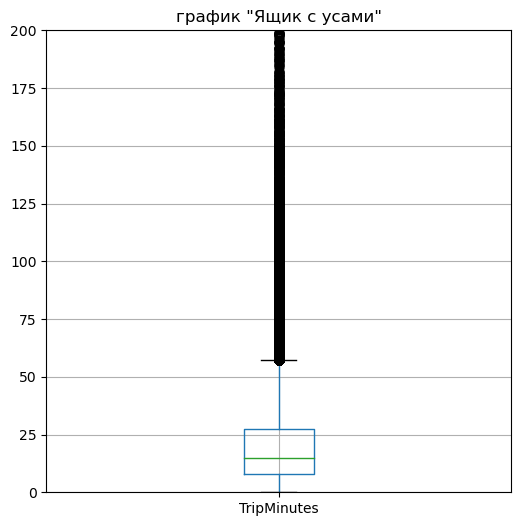


TripKm
  summary              TripKm
0   count             1016615
1    mean  10.122462746615673
2  stddev  12.721624748280414
3     min                 0.0
4     25%  1.4489999616146088
5     50%   4.347000076770783
6     75%  18.176899938583375
7     max  3360.9555786132814


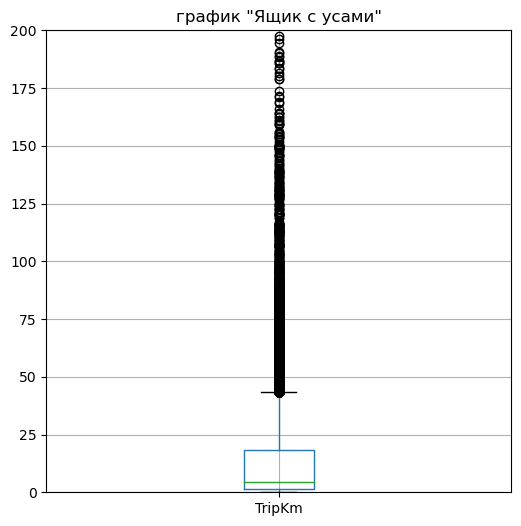

In [27]:
for sign in ['TripMinutes', 'TripKm']:
    print(sign)
    print(sampled_df_new_col_2[[sign]].summary().toPandas())
    sampled_df_new_col_2.select(sign).toPandas().boxplot(figsize=(6, 6))
    plt.title('график "Ящик с усами"')
    plt.ylim(0, 200)
    plt.show()
    print()

Посмотрим на столбцы TripStartTimestamp и TripEndTimestamp

В нашей выборке представлены данные с 1 января по 31 декабря 2022 г.

In [28]:
#TripStartTimestamp, TripEndTimestamp
for sign in ['TripStartTimestamp', 'TripEndTimestamp']:
    print(sampled_df_new_col_2[[sign]].summary().toPandas())
    print()

  summary      TripStartTimestamp
0   count                 1016620
1    mean                    None
2  stddev                    None
3     min  01/01/2022 01:00:00 AM
4     25%                    None
5     50%                    None
6     75%                    None
7     max  12/31/2022 12:45:00 PM

  summary        TripEndTimestamp
0   count                 1016594
1    mean                    None
2  stddev                    None
3     min  01/01/2022 01:00:00 AM
4     25%                    None
5     50%                    None
6     75%                    None
7     max  12/31/2022 12:45:00 PM



В столбцах PickupCommunityArea и DropoffCommunityArea нам дана информация о номерах общественных зон (CommunityArea), где поездка началась и закончилась

In [29]:
#PickupCommunityArea, DropoffCommunityArea
display(sampled_df_new_col_2[['PickupCommunityArea', 'DropoffCommunityArea']].limit(5).toPandas())

,PickupCommunityArea,DropoffCommunityArea
0,33.0,33.0
1,32.0,28.0
2,8.0,7.0
3,1.0,NaN
4,8.0,8.0


In [30]:
print(sampled_df_new_col_2[['PickupCommunityArea', 'DropoffCommunityArea']].distinct().show())

+-------------------+--------------------+
|PickupCommunityArea|DropoffCommunityArea|
+-------------------+--------------------+
|                8.0|                28.0|
|               76.0|                28.0|
|               77.0|                 2.0|
|               56.0|                24.0|
|               12.0|                31.0|
|               38.0|                41.0|
|               34.0|                28.0|
|               40.0|                33.0|
|               77.0|                19.0|
|               40.0|                60.0|
|               61.0|                71.0|
|               33.0|                45.0|
|               16.0|                 5.0|
|               47.0|                34.0|
|               40.0|                61.0|
|               52.0|                39.0|
|               55.0|                77.0|
|               69.0|                59.0|
|               31.0|                 7.0|
|               35.0|                51.0|
+----------

In [31]:
#PickupCommunityArea
print(sampled_df_new_col_2.groupBy('PickupCommunityArea').agg({'PickupCommunityArea': 'count'}).sort('count(PickupCommunityArea)', \
                                                                                     ascending=False).show())

+-------------------+--------------------------+
|PickupCommunityArea|count(PickupCommunityArea)|
+-------------------+--------------------------+
|                8.0|                    229881|
|               76.0|                    173349|
|               32.0|                    164386|
|               28.0|                     87170|
|               33.0|                     37766|
|                6.0|                     36056|
|               56.0|                     31649|
|                7.0|                     23111|
|                3.0|                     15926|
|               77.0|                     11965|
|               24.0|                     11571|
|                2.0|                      7715|
|               41.0|                      7051|
|               35.0|                      5699|
|                1.0|                      5671|
|               38.0|                      5225|
|               43.0|                      5209|
|               22.0

In [32]:
#DropoffCommunityArea
print(sampled_df_new_col_2.groupBy('DropoffCommunityArea').agg({'DropoffCommunityArea': 'count'}).sort('count(DropoffCommunityArea)', \
                                                                                     ascending=False).show())

+--------------------+---------------------------+
|DropoffCommunityArea|count(DropoffCommunityArea)|
+--------------------+---------------------------+
|                 8.0|                     234019|
|                32.0|                     156121|
|                28.0|                      90816|
|                76.0|                      55831|
|                 6.0|                      47036|
|                33.0|                      41911|
|                 7.0|                      40071|
|                24.0|                      26690|
|                 3.0|                      19932|
|                77.0|                      15325|
|                56.0|                      14734|
|                22.0|                      11630|
|                41.0|                       9386|
|                 2.0|                       8767|
|                 1.0|                       7523|
|                 5.0|                       7513|
|                 4.0|         

В столбцах PickupCentroidLocation и DropoffCentroidLocation нам дана информация о координатах центра общественной зоны или переписного участка (census tract)

In [33]:
#PickupCentroidLocation, DropoffCentroidLocation
print(sampled_df_new_col_2[['PickupCentroidLocation', 'DropoffCentroidLocation']].distinct().show())

+----------------------+-----------------------+
|PickupCentroidLocation|DropoffCentroidLocation|
+----------------------+-----------------------+
|  POINT (-87.631863...|   POINT (-87.635760...|
|  POINT (-87.620762...|                   null|
|  POINT (-87.903039...|   POINT (-87.640901...|
|  POINT (-87.620334...|   POINT (-87.683834...|
|  POINT (-87.619710...|   POINT (-87.632746...|
|  POINT (-87.534902...|   POINT (-87.572717...|
|                  null|   POINT (-87.620762...|
|  POINT (-87.617931...|   POINT (-87.635739...|
|  POINT (-87.656305...|   POINT (-87.602350...|
|  POINT (-87.617931...|   POINT (-87.586348...|
|  POINT (-87.663517...|   POINT (-87.723583...|
|  POINT (-87.625192...|   POINT (-87.765501...|
|  POINT (-87.594925...|   POINT (-87.602847...|
|  POINT (-87.655998...|   POINT (-87.696435...|
|  POINT (-87.669054...|   POINT (-87.713192...|
|  POINT (-87.687515...|   POINT (-87.596183...|
|  POINT (-87.913624...|   POINT (-87.592310...|
|  POINT (-87.648787

Медианное значение оплаты поездок, включающей чаевые и доп. плату, составляет 17 долларов США. При этом встречаются аномальные значения от 500 до 9000 долларов США, отработаем их в дальнейшем

  summary          TripTotal
0   count            1015724
1    mean  27.03746241742529
2  stddev  50.58114062598746
3     min                0.0
4     25%               10.0
5     50%              17.25
6     75%              41.25
7     max            9700.31


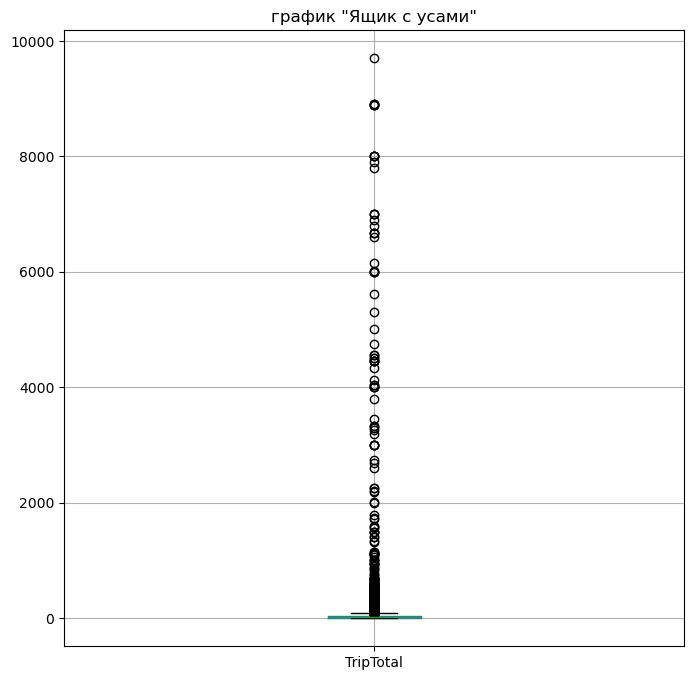

In [34]:
#TripTotal
print(sampled_df_new_col_2[['TripTotal']].summary().toPandas())
sampled_df_new_col_2.select('TripTotal').toPandas().boxplot(figsize=(8, 8))
plt.title('график "Ящик с усами"')
plt.show()

Также нам предоставлена информация о способах оплаты проезда

In [35]:
#PaymentType
print(sampled_df_new_col_2[['PaymentType']].distinct().show())

+-----------+
|PaymentType|
+-----------+
|Credit Card|
|  No Charge|
|    Unknown|
|     Prcard|
|       Cash|
|    Dispute|
|     Mobile|
|    Prepaid|
+-----------+

None


Чаще всего клиенты оплачивают поздки с помощью кредитных карт и наличными. На третьем месте по популярности - мобильный телефон

In [36]:
print(sampled_df_new_col_2.groupBy('PaymentType').agg({'PaymentType': 'count'}).sort('count(PaymentType)', \
                                                                                     ascending=False).show())

+-----------+------------------+
|PaymentType|count(PaymentType)|
+-----------+------------------+
|Credit Card|            399983|
|       Cash|            320116|
|     Mobile|            150900|
|     Prcard|             96589|
|    Unknown|             48114|
|  No Charge|               484|
|    Dispute|               433|
|    Prepaid|                 1|
+-----------+------------------+

None


#### Аномалии

Доля аномальных значений в признаках TripMinutes (более 6 ч.), TripKm (более 400 км.) мала - избавимся от них

In [37]:
#TripMinutes, TripKm
print('Доля аномальных значений в', 'TripMinutes', sampled_df_new_col_2.select('TripID').\
      where(sampled_df_new_col_2.TripMinutes > 360).count() / sampled_df_new_col_2[['TripID']].count())
print('Доля аномальных значений в', 'TripKm', sampled_df_new_col_2.select('TripID').\
      where(sampled_df_new_col_2.TripKm > 400).count() / sampled_df_new_col_2[['TripID']].count())

Доля аномальных значений в TripMinutes 0.0008685644586964648
Доля аномальных значений в TripKm 1.9673034172060356e-05


Доля нулевых значений в признаках TripMinutes и TripKm существенно больше, однако это также аномалия, от которой необходимо избавиться

In [38]:
print('Доля нулевых значений в', 'TripMinutes', sampled_df_new_col_2.select('TripID').\
      where(sampled_df_new_col_2.TripMinutes == 0).count() / sampled_df_new_col_2[['TripID']].count())
print('Доля нулевых значений в', 'TripKm', sampled_df_new_col_2.select('TripID').\
      where(sampled_df_new_col_2.TripKm == 0).count() / sampled_df_new_col_2[['TripID']].count())

Доля нулевых значений в TripMinutes 0.022774488009285672
Доля нулевых значений в TripKm 0.11785032755601897


Доля аномальных и нулевых значений в TripTotal незначительна

In [39]:
#TripTotal
print('Доля аномальных значений в', 'TripTotal', sampled_df_new_col_2.select('TripID').\
      where(sampled_df_new_col_2.TripTotal > 500).count() / sampled_df_new_col_2[['TripID']].count())
print('Доля нулевых значений в', 'TripTotal', sampled_df_new_col_2.select('TripID').\
      where(sampled_df_new_col_2.TripTotal == 0).count() / sampled_df_new_col_2[['TripID']].count())

Доля аномальных значений в TripTotal 0.00014164584603883456
Доля нулевых значений в TripTotal 0.0008665971552792587


Избавились от аномалий

In [40]:
sampled_df_no_anom = sampled_df_new_col_2.where(sampled_df_new_col_2.TripMinutes <= 360)
sampled_df_no_anom = sampled_df_no_anom.where(sampled_df_no_anom.TripKm <= 360)
sampled_df_no_anom = sampled_df_no_anom.where(sampled_df_no_anom.TripMinutes > 0)
sampled_df_no_anom = sampled_df_no_anom.where(sampled_df_no_anom.TripKm > 0)
sampled_df_no_anom = sampled_df_no_anom.where(sampled_df_no_anom.TripTotal < 500)
sampled_df_no_anom = sampled_df_no_anom.where(sampled_df_no_anom.TripTotal > 0)

Наша выборка сократилась на 12%

In [41]:
print(sampled_df_new_col_2[['TripID']].count())
print(sampled_df_no_anom[['TripID']].count())
print((sampled_df_no_anom[['TripID']].count() / sampled_df_new_col_2[['TripID']].count()) - 1)

1016620
893717
-0.12089374594243674


#### Пропуски

Пропуски зафиксированы в столбцах, характеризующих место посадки и высадки пассажира: PickupCommunityArea, DropoffCommunityArea, PickupCentroidLocation, DropoffCentroidLocation. Максимальная доля пропусков в указанных столбцах не превышает 10%. В описании сказано, что указанные поля могут быть пустыми, если поездка началась/закончилась за пределами Чикаго. Заполним пропуски в столбцах PickupCommunityArea, DropoffCommunityArea произвольным значением (например, 99.0), которое будет обозначать "за пределами Чикаго". От столбцов PickupCentroidLocation и DropoffCentroidLocation в целом в дальнейшем мы избавимся

In [42]:
sampled_df_no_anom.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in sampled_df_no_anom.columns]).show()

+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+
|TripID|TripStartTimestamp|TripEndTimestamp|TripSeconds|TripMiles|PickupCommunityArea|DropoffCommunityArea|TripTotal|PaymentType|PickupCentroidLocation|DropoffCentroidLocation|TripMinutes|TripKm|
+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+
|     0|                 0|               0|          0|        0|              59251|               85827|        0|          0|                 59144|                  80351|          0|     0|
+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+



In [43]:
sampled_df_no_anom = sampled_df_no_anom.fillna(99.0)

От столбцов PickupCentroidLocation и DropoffCentroidLocation избавимся в дальнейшем

In [44]:
#повторная проверка
sampled_df_no_anom.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in sampled_df_no_anom.columns]).show()

+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+
|TripID|TripStartTimestamp|TripEndTimestamp|TripSeconds|TripMiles|PickupCommunityArea|DropoffCommunityArea|TripTotal|PaymentType|PickupCentroidLocation|DropoffCentroidLocation|TripMinutes|TripKm|
+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+
|     0|                 0|               0|          0|        0|                  0|                   0|        0|          0|                 59144|                  80351|          0|     0|
+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+



#### Повторно убираем бесполезные признаки

In [45]:
sampled_df_no_anom.printSchema()

root
 |-- TripID: string (nullable = true)
 |-- TripStartTimestamp: string (nullable = true)
 |-- TripEndTimestamp: string (nullable = true)
 |-- TripSeconds: float (nullable = false)
 |-- TripMiles: float (nullable = false)
 |-- PickupCommunityArea: float (nullable = false)
 |-- DropoffCommunityArea: float (nullable = false)
 |-- TripTotal: float (nullable = false)
 |-- PaymentType: string (nullable = true)
 |-- PickupCentroidLocation: string (nullable = true)
 |-- DropoffCentroidLocation: string (nullable = true)
 |-- TripMinutes: double (nullable = false)
 |-- TripKm: double (nullable = false)



In [46]:
#повторно убрать бесполезные признаки
unessen_col = ['TripSeconds', 'TripMiles', 'PickupCentroidLocation', 'DropoffCentroidLocation', 'TripStartDate',\
               'TripEndTimestamp']
sampled_df_essen_2 = sampled_df_no_anom.drop(*unessen_col)
sampled_df_essen_2.printSchema()

root
 |-- TripID: string (nullable = true)
 |-- TripStartTimestamp: string (nullable = true)
 |-- PickupCommunityArea: float (nullable = false)
 |-- DropoffCommunityArea: float (nullable = false)
 |-- TripTotal: float (nullable = false)
 |-- PaymentType: string (nullable = true)
 |-- TripMinutes: double (nullable = false)
 |-- TripKm: double (nullable = false)



### Анализ трендов и сезонности

Видны тренды на рост активности использования такси с января по май и снижение с октября по январь. Замечено сезонное снижение кол-ва заказов такси в январе, а также в июле-августе. Это может быть связано с отпусками, которые часто берут в указанные месяцы

Видны тренды на рост активности использования такси с понедельника по четверг и снижение с пятницы по воскресенье

In [47]:
sampled_df_essen_2.printSchema()

root
 |-- TripID: string (nullable = true)
 |-- TripStartTimestamp: string (nullable = true)
 |-- PickupCommunityArea: float (nullable = false)
 |-- DropoffCommunityArea: float (nullable = false)
 |-- TripTotal: float (nullable = false)
 |-- PaymentType: string (nullable = true)
 |-- TripMinutes: double (nullable = false)
 |-- TripKm: double (nullable = false)



In [48]:
unessen_col = ['PickupCommunityArea', 'DropoffCommunityArea', 'TripTotal', 'PaymentType', 'TripMinutes', 'TripKm']
sampled_df_essen_2 = sampled_df_essen_2.drop(*unessen_col)

In [49]:
display(sampled_df_essen_2.limit(5).toPandas())

,TripID,TripStartTimestamp
0,3f11e5abdb93e75abfb97bb9c27d166ebcf0abd4,01/01/2022 12:00:00 AM
1,e585d6e2ea7ab5c9c4d75447b8cb74d9df08fab4,01/01/2022 12:00:00 AM
2,3184bc678ef5f2cdd230cde6098eab9239282804,01/01/2022 12:00:00 AM
3,c15cd6d8c616db38c8df51b4cfc2bfaa4bd70076,01/01/2022 12:00:00 AM
4,0107b1f0ac4333e551bf5344cc4882f69167b1ca,01/01/2022 12:15:00 AM


In [50]:
#изменили тип данных TripStartTimestamp
sampled_df_chan_typ = sampled_df_essen_2.withColumn('TripStartTimestamp',\
                                                    F.to_timestamp(col('TripStartTimestamp'),'MM/dd/yyyy hh:mm:ss a'))
sampled_df_chan_typ.printSchema()
display(sampled_df_chan_typ.limit(5).toPandas())

root
 |-- TripID: string (nullable = true)
 |-- TripStartTimestamp: timestamp (nullable = true)



/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,TripID,TripStartTimestamp
0,3f11e5abdb93e75abfb97bb9c27d166ebcf0abd4,2022-01-01 00:00:00
1,e585d6e2ea7ab5c9c4d75447b8cb74d9df08fab4,2022-01-01 00:00:00
2,3184bc678ef5f2cdd230cde6098eab9239282804,2022-01-01 00:00:00
3,c15cd6d8c616db38c8df51b4cfc2bfaa4bd70076,2022-01-01 00:00:00
4,0107b1f0ac4333e551bf5344cc4882f69167b1ca,2022-01-01 00:15:00


In [51]:
#сжали в почасовые данные
sampled_df_hours = sampled_df_chan_typ.groupBy(F.date_trunc('hour', 'TripStartTimestamp').alias('date_hour')) \
                   .agg(F.count('TripID').alias('count_orders'), 
                        ).sort('date_hour', ascending=True)

In [52]:
sampled_df_hours.printSchema()

root
 |-- date_hour: timestamp (nullable = true)
 |-- count_orders: long (nullable = false)



In [53]:
display(sampled_df_hours.limit(5).toPandas())

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,date_hour,count_orders
0,2022-01-01 00:00:00,39
1,2022-01-01 01:00:00,47
2,2022-01-01 02:00:00,50
3,2022-01-01 03:00:00,37
4,2022-01-01 04:00:00,15


In [54]:
sampled_df_seas_anl = sampled_df_hours.toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Даты расположены в хронологическом порядке

In [55]:
print(sampled_df_seas_anl.index.is_monotonic)

True


/tmp/ipykernel_106/3889858832.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print(sampled_df_seas_anl.index.is_monotonic)


In [56]:
#None
print(sampled_df_seas_anl.loc[sampled_df_seas_anl['count_orders'] == 'None', 'date_hour'].count())

0


In [57]:
print(sampled_df_seas_anl.isna().sum())

date_hour       0
count_orders    0
dtype: int64


In [58]:
#устанавливаем столбец date_hour в качестве индекса
sampled_df_seas_anl_ind = sampled_df_seas_anl.set_index('date_hour')
display(sampled_df_seas_anl_ind.head(10))

,count_orders
date_hour,
2022-01-01 00:00:00,39
2022-01-01 01:00:00,47
2022-01-01 02:00:00,50
2022-01-01 03:00:00,37
2022-01-01 04:00:00,15
2022-01-01 05:00:00,14
2022-01-01 06:00:00,10
2022-01-01 07:00:00,11
2022-01-01 08:00:00,17


Осуществили ресемплирование до 1 дня

In [59]:
sampled_df_1d = sampled_df_seas_anl_ind.resample('1D').sum()

Видны тренды на рост активности использования такси с января по май и снижение с октября по январь. Замечено сезонное снижение кол-ва заказов такси в январе, а также в июле-августе. Это может быть связано с отпусками, которые часто берут в указанные месяцы

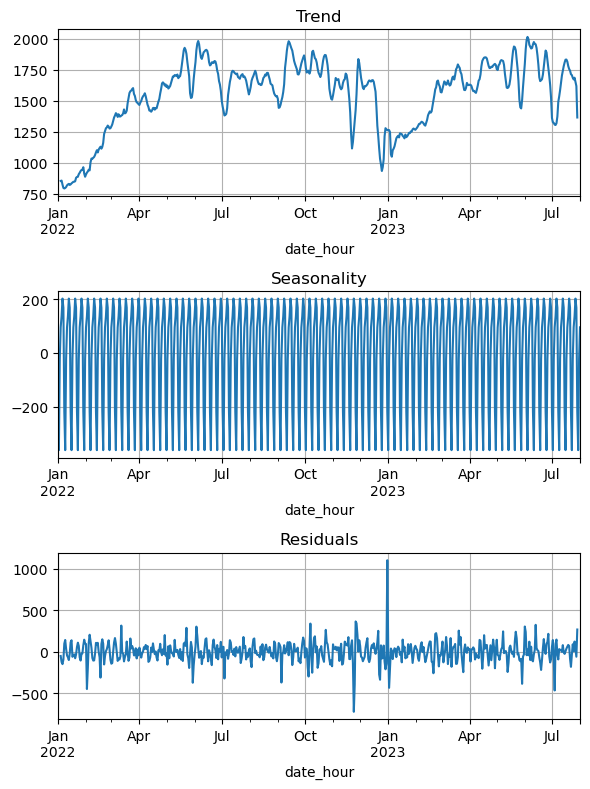

In [60]:
#анализируем тренды и сезонность
#.count_orders, не помогло
#['count_orders'], не помогло
decomposed = seasonal_decompose(sampled_df_1d)
plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), grid=True)
#decomposed.seasonal.tail.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), grid=True)
plt.title('Residuals')
plt.tight_layout()
plt.show();

Видны тренды на рост активности использования такси с понедельника по четверг и снижение с пятницы по воскресенье

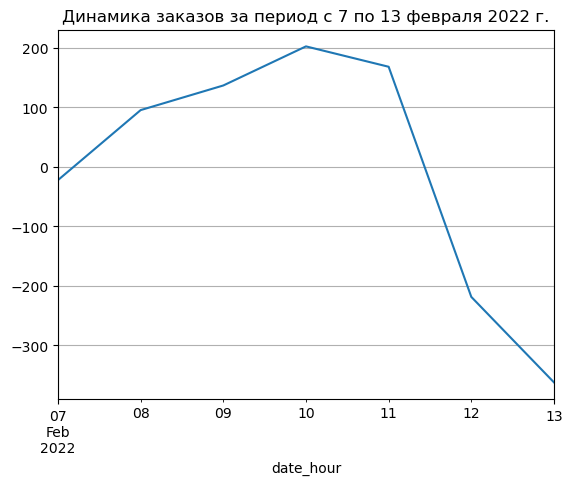

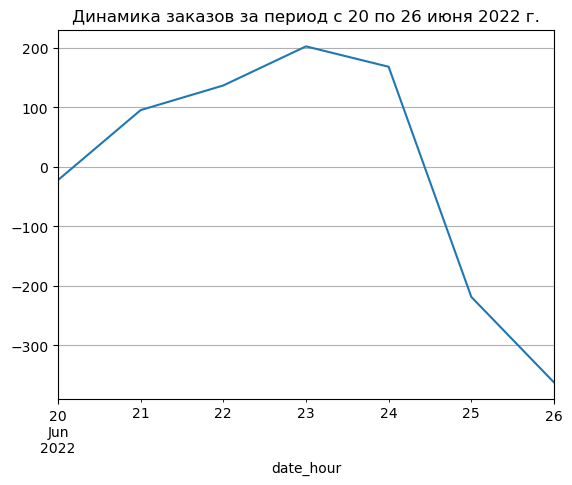

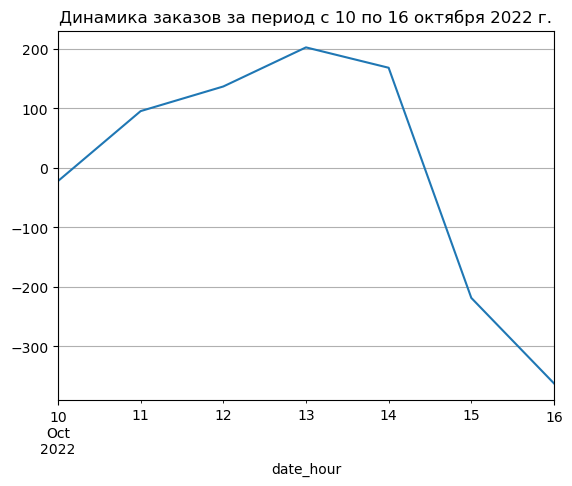

In [61]:
#посмотрим детальнее на дневную сезонность
decomposed.seasonal['2022-02-07':'2022-02-13'].plot(grid=True);
plt.title('Динамика заказов за период с 7 по 13 февраля 2022 г.');
plt.show()
print()
decomposed.seasonal['2022-06-20':'2022-06-26'].plot(grid=True);
plt.title('Динамика заказов за период с 20 по 26 июня 2022 г.');
plt.show()
print()
decomposed.seasonal['2022-10-10':'2022-10-16'].plot(grid=True);
plt.title('Динамика заказов за период с 10 по 16 октября 2022 г.');
plt.show();

### По аналогии с нашей выборкой поработаем со всеми представленными данными

Избавились от бесполезных признаков во всех представленных данных

In [62]:
#избавляемся от бесполезных признаков
unessen_col = ['Taxi ID', 'Company', 'Fare', 'Tips', 'Tolls', 'Extras', 'Pickup Census Tract',\
                                 'Dropoff Census Tract', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude',\
                                   'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']

In [63]:
df_essen = df.drop(*unessen_col)
display(df_essen.limit(5).toPandas())

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Trip Total,Payment Type,Pickup Centroid Location,Dropoff Centroid Location
0,bcfa19f2539021c054809d4c3993d226996ae095,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,152.0,0.100000,NaN,NaN,3.75,Cash,None,None
1,2aba69ff015f9ea8e7bff43cab7eddb228f34a12,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2360.0,17.440001,NaN,8.0,52.75,Cash,None,POINT (-87.6333080367 41.899602111)
2,54d812a0b88f8f9707825261014b3563a0a60ace,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,536.0,4.830000,28.0,22.0,14.75,Cash,POINT (-87.6635175498 41.874005383),POINT (-87.6991553432 41.9227606205)
3,7125b9e03a0f16c2dfb5eaf73ed057dc51eb68ef,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,897.0,2.070000,8.0,32.0,11.25,Cash,POINT (-87.6333080367 41.899602111),POINT (-87.6251921424 41.8788655841)
4,f1a650ee419b4e52d766432e6f86eca3457bfb37,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2200.0,2.480000,8.0,32.0,11.50,Mobile,POINT (-87.6333080367 41.899602111),POINT (-87.6251921424 41.8788655841)


В генеральной совокупности явные дубликаты также не выявлены

In [64]:
#явные дубликаты
print(df_essen.count())
print(df_essen.distinct().count())

10166155
10166155


Изменили названия столбцов

In [65]:
#изменяем названия столбцов
oldColumns = df_essen.schema.names
newColumns = ['TripID', 'TripStartTimestamp', 'TripEndTimestamp', 'TripSeconds', 'TripMiles', 'PickupCommunityArea',\
              'DropoffCommunityArea', 'TripTotal', 'PaymentType', 'PickupCentroidLocation', 'DropoffCentroidLocation']
df_new_names = reduce(lambda df_essen, idx: df_essen.withColumnRenamed(oldColumns[idx], newColumns[idx]),\
                              range(len(oldColumns)), df_essen)
display(df_new_names.limit(5).toPandas())

,TripID,TripStartTimestamp,TripEndTimestamp,TripSeconds,TripMiles,PickupCommunityArea,DropoffCommunityArea,TripTotal,PaymentType,PickupCentroidLocation,DropoffCentroidLocation
0,bcfa19f2539021c054809d4c3993d226996ae095,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,152.0,0.100000,NaN,NaN,3.75,Cash,None,None
1,2aba69ff015f9ea8e7bff43cab7eddb228f34a12,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2360.0,17.440001,NaN,8.0,52.75,Cash,None,POINT (-87.6333080367 41.899602111)
2,54d812a0b88f8f9707825261014b3563a0a60ace,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,536.0,4.830000,28.0,22.0,14.75,Cash,POINT (-87.6635175498 41.874005383),POINT (-87.6991553432 41.9227606205)
3,7125b9e03a0f16c2dfb5eaf73ed057dc51eb68ef,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,897.0,2.070000,8.0,32.0,11.25,Cash,POINT (-87.6333080367 41.899602111),POINT (-87.6251921424 41.8788655841)
4,f1a650ee419b4e52d766432e6f86eca3457bfb37,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2200.0,2.480000,8.0,32.0,11.50,Mobile,POINT (-87.6333080367 41.899602111),POINT (-87.6251921424 41.8788655841)


Добавили новые признаки

In [66]:
#добавим новые столбцы TripMinutes и TripKm
df_new_col = df_new_names.withColumn('TripMinutes', df_new_names['TripSeconds'] / 60)
df_new_col_2 = df_new_col.withColumn('TripKm', df_new_col['TripMiles'] * 1.61)
display(df_new_col_2.limit(5).toPandas())

,TripID,TripStartTimestamp,TripEndTimestamp,TripSeconds,TripMiles,PickupCommunityArea,DropoffCommunityArea,TripTotal,PaymentType,PickupCentroidLocation,DropoffCentroidLocation,TripMinutes,TripKm
0,bcfa19f2539021c054809d4c3993d226996ae095,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,152.0,0.100000,NaN,NaN,3.75,Cash,None,None,2.533333,0.161000
1,2aba69ff015f9ea8e7bff43cab7eddb228f34a12,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2360.0,17.440001,NaN,8.0,52.75,Cash,None,POINT (-87.6333080367 41.899602111),39.333333,28.078401
2,54d812a0b88f8f9707825261014b3563a0a60ace,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,536.0,4.830000,28.0,22.0,14.75,Cash,POINT (-87.6635175498 41.874005383),POINT (-87.6991553432 41.9227606205),8.933333,7.776300
3,7125b9e03a0f16c2dfb5eaf73ed057dc51eb68ef,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,897.0,2.070000,8.0,32.0,11.25,Cash,POINT (-87.6333080367 41.899602111),POINT (-87.6251921424 41.8788655841),14.950000,3.332700
4,f1a650ee419b4e52d766432e6f86eca3457bfb37,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2200.0,2.480000,8.0,32.0,11.50,Mobile,POINT (-87.6333080367 41.899602111),POINT (-87.6251921424 41.8788655841),36.666667,3.992800


In [67]:
#TripMinutes
print(df_new_col_2[['TripMinutes']].summary().toPandas())

  summary         TripMinutes
0   count            10163972
1    mean   20.20040440226805
2  stddev  30.635762386033477
3     min                 0.0
4     25%                7.75
5     50%  14.816666666666666
6     75%  27.533333333333335
7     max  1439.0166666666667


In [68]:
QUAN_LO = 7.75
QUAN_HI = 27.5

In [69]:
iqr_trip_min = QUAN_HI + 1.5 * (QUAN_HI - QUAN_LO)
print('IQR', iqr_trip_min)

IQR 57.125


In [70]:
#TripKm
print(df_new_col_2[['TripKm']].summary().toPandas())

  summary              TripKm
0   count            10166086
1    mean  10.129943444989891
2  stddev  12.645162292249129
3     min                 0.0
4     25%  1.4489999616146088
5     50%   4.347000076770783
6     75%  18.193000307083132
7     max   4777.739462890625


In [71]:
QUAN_LO = 1.45
QUAN_HI = 18.19

In [72]:
iqr_trip_km = QUAN_HI + 1.5 * (QUAN_HI - QUAN_LO)
print('IQR', iqr_trip_km)

IQR 43.300000000000004


In [73]:
#TripTotal
print(df_new_col_2[['TripTotal']].summary().toPandas())

  summary          TripTotal
0   count           10157216
1    mean  27.02821500466409
2  stddev  50.47904828620873
3     min                0.0
4     25%               10.0
5     50%              17.25
6     75%              41.25
7     max            9999.75


In [74]:
QUAN_LO = 10
QUAN_HI = 41.25

In [75]:
iqr_trip_tot = QUAN_HI + 1.5 * (QUAN_HI - QUAN_LO)
print('IQR', iqr_trip_tot)

IQR 88.125


Устранили аномалии с использованием IQR

In [76]:
#работаем с аномалиями
df_no_anom = df_new_col_2.where(df_new_col_2.TripMinutes <= iqr_trip_min)
df_no_anom = df_no_anom.where(df_no_anom.TripKm <= iqr_trip_km)
df_no_anom = df_no_anom.where(df_no_anom.TripTotal <= iqr_trip_tot)

df_no_anom = df_no_anom.where(df_no_anom.TripKm > 0)
df_no_anom = df_no_anom.where(df_no_anom.TripTotal > 0)
df_no_anom = df_no_anom.where(df_no_anom.TripMinutes > 0)

Объем данных сократился на 16%

In [77]:
print(df_new_col_2[['TripID']].count())
print(df_no_anom[['TripID']].count())
print((df_no_anom[['TripID']].count() / df_new_col_2[['TripID']].count()) - 1)

10166155
8520388
-0.16188686873257396


Отработали пропуски в столбцах PickupCommunityArea и DropoffCommunityArea

In [78]:
#отрабатываем пропуски
df_no_anom.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_no_anom.columns]).show()

+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+
|TripID|TripStartTimestamp|TripEndTimestamp|TripSeconds|TripMiles|PickupCommunityArea|DropoffCommunityArea|TripTotal|PaymentType|PickupCentroidLocation|DropoffCentroidLocation|TripMinutes|TripKm|
+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+
|     0|                 0|               0|          0|        0|             533790|              728267|        0|          0|                532905|                 675803|          0|     0|
+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+



In [79]:
df_no_anom = df_no_anom.fillna(99.0)
df_no_anom.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_no_anom.columns]).show()

+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+
|TripID|TripStartTimestamp|TripEndTimestamp|TripSeconds|TripMiles|PickupCommunityArea|DropoffCommunityArea|TripTotal|PaymentType|PickupCentroidLocation|DropoffCentroidLocation|TripMinutes|TripKm|
+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+
|     0|                 0|               0|          0|        0|                  0|                   0|        0|          0|                532905|                 675803|          0|     0|
+------+------------------+----------------+-----------+---------+-------------------+--------------------+---------+-----------+----------------------+-----------------------+-----------+------+



Повторно убрали бесполезные признаки

In [80]:
#повторно убрать бесполезные признаки
unessen_col = ['TripSeconds', 'TripMiles', 'PickupCentroidLocation', 'DropoffCentroidLocation', 'TripStartDate',\
               'TripEndTimestamp', 'TripID', 'DropoffCommunityArea', 'PaymentType']
df_essen_2 = df_no_anom.drop(*unessen_col)
df_essen_2.printSchema()

root
 |-- TripStartTimestamp: string (nullable = true)
 |-- PickupCommunityArea: float (nullable = false)
 |-- TripTotal: float (nullable = false)
 |-- TripMinutes: double (nullable = false)
 |-- TripKm: double (nullable = false)



In [81]:
#изменили тип данных TripStartTimestamp, TripEndTimestamp, 
df_chan_typ = df_essen_2.withColumn('TripStartTimestamp',\
                                                    F.to_timestamp(col('TripStartTimestamp'),'MM/dd/yyyy hh:mm:ss a'))
df_chan_typ.printSchema()
display(df_chan_typ.limit(5).toPandas())

root
 |-- TripStartTimestamp: timestamp (nullable = true)
 |-- PickupCommunityArea: float (nullable = false)
 |-- TripTotal: float (nullable = false)
 |-- TripMinutes: double (nullable = false)
 |-- TripKm: double (nullable = false)



/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,TripStartTimestamp,PickupCommunityArea,TripTotal,TripMinutes,TripKm
0,2022-01-01,99.0,3.75,2.533333,0.161000
1,2022-01-01,99.0,52.75,39.333333,28.078401
2,2022-01-01,28.0,14.75,8.933333,7.776300
3,2022-01-01,8.0,11.25,14.950000,3.332700
4,2022-01-01,8.0,11.50,36.666667,3.992800


Сжали в почасовые данные

In [82]:
df_hours = df_chan_typ.groupBy(F.date_trunc('hour', 'TripStartTimestamp').alias('date_hour'), 'PickupCommunityArea') \
                   .agg(F.sum('TripTotal').alias('sum_trip_total'),
                        F.sum('TripMinutes').alias('sum_trip_minutes'),
                        F.sum('TripKm').alias('sum_trip_km'),
                        F.count('*').alias('count_orders'), 
                        ).sort('date_hour', ascending=True)

In [83]:
df_hours.printSchema()

root
 |-- date_hour: timestamp (nullable = true)
 |-- PickupCommunityArea: float (nullable = false)
 |-- sum_trip_total: double (nullable = true)
 |-- sum_trip_minutes: double (nullable = true)
 |-- sum_trip_km: double (nullable = true)
 |-- count_orders: long (nullable = false)



### Добавляем новые признаки

В качестве новых признаков добавили день недели и час

In [84]:
#день недели, час
df_new_time_ser_col = df_hours.withColumn('day_of_week', dayofweek('date_hour'))
df_new_time_ser_col = df_new_time_ser_col.withColumn('hour', hour('date_hour'))

In [85]:
display(df_new_time_ser_col.limit(5).toPandas())

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,date_hour,PickupCommunityArea,sum_trip_total,sum_trip_minutes,sum_trip_km,count_orders,day_of_week,hour
0,2022-01-01,33.0,93.27,86.600000,42.326901,4,7,0
1,2022-01-01,25.0,63.25,44.516667,37.496900,2,7,0
2,2022-01-01,41.0,68.00,71.166667,21.767200,2,7,0
3,2022-01-01,77.0,112.75,127.866667,49.620200,6,7,0
4,2022-01-01,2.0,36.50,31.633333,16.599101,3,7,0


In [86]:
df_new_time_ser_col[['hour']].distinct().show()

+----+
|hour|
+----+
|  12|
|  22|
|   1|
|  13|
|  16|
|   6|
|   3|
|  20|
|   5|
|  19|
|  15|
|  17|
|   9|
|   4|
|   8|
|  23|
|   7|
|  10|
|  21|
|  11|
+----+
only showing top 20 rows



## Работа с моделями

Определили функцию для разделения представленных данных на обучающую и тестовую выборки

In [87]:
def prep_samples(df, area):
    df_area = df.select('*').where(df.PickupCommunityArea == area)
    #делим выборку на обучающую и тестовую
    df_area = df_area.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("date_hour")))
    #train, test = df_area.randomSplit([0.75, 0.25], seed=SEED)
    train = df_area.where("rank <= .75").drop("rank")
    test = df_area.where("rank > .75").drop("rank")
    return train, test

Все необходимые нам признаки численные, поэтому определили функцию для осуществления только масштабирования переменных, их кодирование не требуется

In [88]:
#масштабирование
def make_scal(tr, te, sign):
    df_test_train = tr.select(
    mean(col(sign)).alias(sign + '_mean'),
    stddev(col(sign)).alias(sign + '_std')
).collect()
    df_test_test = te.select(
    mean(col(sign)).alias(sign + '_mean'),
    stddev(col(sign)).alias(sign + '_std')
).collect()
    
    mean_train = df_test_train[0][sign + '_mean']
    std_train = df_test_train[0][sign + '_std']
       
    mean_test = df_test_test[0][sign + '_mean']
    std_test = df_test_test[0][sign + '_std']
    return mean_train, std_train, mean_test, std_test

Запустили определенные выше функции, а также непосредственно создание и обучение модели (grid search, кросс-валидацию) в цикле по каждому community. В качестве модели выбрали логистическую регрессию

In [89]:
%%time

mae_list = []
area_list = []
model_list = []
index = 1

#df_new_time_ser_col
#sampled_df_new_time_ser_col
df_areas = df_new_time_ser_col[['PickupCommunityArea']].distinct().toPandas()
for a in df_areas['PickupCommunityArea']:
    print('регион №', a)
    #делим на выборки
    #df_new_time_ser_col
    #sampled_df_new_time_ser_col
    train, test = prep_samples(df_new_time_ser_col, a)
        
    #добавляем лаги отдельно для train и test
    w = Window.partitionBy().orderBy("date_hour")
    train = train.withColumn("count_orders_prev_hour", lag("count_orders", 1, 0).over(w))
    train = train.withColumn("count_orders_prev_day", lag("count_orders", 24, 0).over(w))
    train = train.withColumn("count_orders_prev_week", lag("count_orders", 168, 0).over(w))

    test = test.withColumn("count_orders_prev_hour", lag("count_orders", 1, 0).over(w))
    test = test.withColumn("count_orders_prev_day", lag("count_orders", 24, 0).over(w))
    test = test.withColumn("count_orders_prev_week", lag("count_orders", 168, 0).over(w))
    
    #масштабируем
    for s in ['sum_trip_total', 'sum_trip_minutes', 'sum_trip_km', 'day_of_week', 'hour', 'count_orders_prev_hour', 'count_orders_prev_day', 'count_orders_prev_week']:
        m_train, s_train, m_test, s_test = make_scal(train, test, s)
        train = train.withColumn(s + '_scal', (train[s] - m_train) / s_train)
        test = test.withColumn(s + '_scal', (test[s] - m_test) / s_test)
    
    #убираем лишние столбцы
    unessen_col = ['date_hour', 'PickupCommunityArea', 'sum_trip_total', 'sum_trip_minutes', 'sum_trip_km', 'day_of_week', 'hour', 'count_orders_prev_hour',\
               'count_orders_prev_day', 'count_orders_prev_week']
    train_ess_col = train.drop(*unessen_col)
    
    #определяем целевой и обучающие признаки
    features = ['sum_trip_total_scal', 'sum_trip_minutes_scal', 'sum_trip_km_scal', 'day_of_week_scal', 'hour_scal', 'count_orders_prev_hour_scal',\
            'count_orders_prev_day_scal', 'count_orders_prev_week_scal']
    target = 'count_orders'
    attributes = features + [target]
    sample = train_ess_col.select(attributes)
    
    #создаем вектор
    assembler = VectorAssembler(inputCols=features, outputCol='features')
    output = assembler.transform(sample)
    
    #определяем модель логистической регрессии
    lin_reg = LinearRegression(featuresCol='features', labelCol='count_orders')
    
    #используем grid_search для подбора гипер-параметров
    grid_search = ParamGridBuilder() \
    .addGrid(lin_reg.regParam, [0.0, 0.01, 0.1]) \
    .addGrid(lin_reg.elasticNetParam, [0.5, 1.0]) \
    .build()
    evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='count_orders')
    
    #обучаем модель кросс-валидацией
    cv = CrossValidator(estimator=lin_reg,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator)
    cv_model = cv.fit(output)
    
    #получаем оценку лучшей модели
    best_mae = cv_model.bestModel.summary.meanAbsoluteError
    print('MAE лучшей модели', best_mae)
    mae_list.append(best_mae)
    area_list.append(a)
    model_list.append(cv_model)
    #> 66
    if index > 66:
        break
    else:
        index += 1
        print()

регион № 18.0
MAE лучшей модели 0.10526041834867146

регион № 64.0
MAE лучшей модели 0.1808106983539887

регион № 47.0
MAE лучшей модели 0.18469332125246077

регион № 9.0
MAE лучшей модели 0.14370473286481572

регион № 58.0
MAE лучшей модели 0.2625807640962947

регион № 39.0
MAE лучшей модели 0.6201404388075485

регион № 5.0
MAE лучшей модели 0.5409656172230041

регион № 17.0
MAE лучшей модели 0.2447106036106694

регион № 30.0
MAE лучшей модели 0.28495485535052795

регион № 26.0
MAE лучшей модели 0.2546654004685964

регион № 41.0
MAE лучшей модели 0.8242073692660891

регион № 99.0
MAE лучшей модели 3.656882015488769

регион № 29.0
MAE лучшей модели 0.2825976135283337

регион № 23.0
MAE лучшей модели 0.30233240956331003

регион № 11.0
MAE лучшей модели 0.4298469544019598

регион № 67.0
MAE лучшей модели 0.2991358018055297

регион № 49.0
MAE лучшей модели 0.38134576507103934

регион № 7.0
MAE лучшей модели 1.6062550320990006

регион № 2.0
MAE лучшей модели 0.8373824279469468

регион № 56

Медианное значение MAE лучших моделей по всем регионам составило 0.38

In [90]:
print(statistics.median(mae_list))

0.3787318171052714


In [91]:
results = pd.DataFrame(np.column_stack([area_list, mae_list, model_list]),
                               columns=['area number', 'mae', 'model name']).sort_values('mae')
display(results)

,area number,mae,model name
0,18.0,0.10526,CrossValidatorModel_e5064078e0fe
56,62.0,0.137827,CrossValidatorModel_daa7d017ded3
3,9.0,0.143705,CrossValidatorModel_e94062dda96c
40,20.0,0.150708,CrossValidatorModel_a22a70d3f5fe
41,57.0,0.177813,CrossValidatorModel_a702a7f91476
...,...,...,...
65,33.0,3.077009,CrossValidatorModel_d14c26ab1c6c
49,76.0,3.286926,CrossValidatorModel_34de54ea7ed6
11,99.0,3.656882,CrossValidatorModel_08f4da7a432d
62,32.0,9.60127,CrossValidatorModel_1bc099cb71f0


## Проверяем качество последней модели на тесте

На тестовой выборке значение MAE модели последнего региона составило 0.39

In [92]:
test_ess_col = test.drop(*unessen_col)
sample_test = test_ess_col.select(attributes)
output_test = assembler.transform(sample_test)

In [93]:
#display(output_test.limit(5).toPandas())

In [94]:
#делаем предсказания
pred = cv_model.transform(output_test)

In [95]:
#display(pred.limit(5).toPandas())

In [96]:
#рассчитываем MAE
pred_new_col = pred.withColumn('abs', abs(pred['count_orders'] - pred['prediction']))

In [97]:
#display(pred_new_col.limit(5).toPandas())

In [98]:
pred_new_col_pd = pred_new_col.toPandas()
print('MAE', pred_new_col_pd['abs'].sum() / pred_new_col_pd['abs'].count())

MAE 0.39469909807761033


## Общий вывод по итогам проведенной работы

- В рамках проекта перед нами была поставлена задача создать модель, которая бы предсказывала кол-во заказов такси на следующий час в каждом округе (community).
- Предварительно данные из csv файлов объединили в один DataFrame.
- Для проведения исследовательского анализа и обработки данных создали репрезентативную выборку.
- В рамках обработки данных проверили наличие дубликатов, убрали бесполезные для анализа признаки, изменили названия столбцов, добавили новые признаки, отработали аномалии и пропуски.

Провели **анализ трендов и сезонности**, в рамках которого выявили тенденциюы на рост активности использования такси с января по май и снижение с октября по январь. Замечено сезонное снижение кол-ва заказов такси в январе, а также в июле-августе.Также в
Видны тренды на рост активности использования такси с понедельника по четверг и снижение с пятницы по воскресене


- По аналогии с выборкой обработали все представленные данные.
- Сжали представленную информацию в почасовые данные.
- В качестве новых временных признаков добавили день недели и час, кол-во заказов в предыдущий час, предыдущий час день назад и предыдущий час неделю назад.

В рамках работы с моделями:
- разделили представленные данные на обучающую и тестовую выборки
- провели масштабирование численных признаков, кодирование признаков не требуется
- в качестве модели выбрали логистическую регрессию
- гипер-параметры выбрали с помощью grid search
- обучение и оценку MAE лучшей модели провели с использованием кросс-валидации

**Медианное значение MAE лучших моделей по всем регионам составило 0.38**

На тестовой выборке значение MAE модели последнего региона составило 0.39